# Computer vision

In [ ]:
from fastai.gen_doc.nbdoc import *

The [`vision`](/vision.html#vision) module of the fastai library contains all the necessary functions to define a Dataset and train a model for computer vision tasks. It contains four different submodules to reach that goal:
- [`vision.image`](/vision.image.html#vision.image) contains the basic definition of an [`Image`](/vision.image.html#Image) object and all the functions that are used behind the scenes to apply transformations to such an object.
- [`vision.transform`](/vision.transform.html#vision.transform) contains all the transforms we can use for data augmentation.
- [`vision.data`](/vision.data.html#vision.data) contains the definition of [`ImageClassificationDataset`](/vision.data.html#ImageClassificationDataset) as well as the utility function to easily build a [`DataBunch`](/basic_data.html#DataBunch) for Computer Vision problems.
- [`vision.learner`](/vision.learner.html#vision.learner) lets you build and fine-tune models with a pretrained CNN backbone or train a randomly initialized model from scratch.

Each of the four module links above includes a quick overview and examples of the functionality of that module, as well as complete API documentation. Below, we'll provide a walk-thru of end to end computer vision model training with the most commonly used functionality.

## Minimal training example

First, import everything you need from the fastai library.

In [ ]:
from fastai.vision import * 
from fastai import *

First, create a data folder containing a MNIST subset in `data/mnist_sample` using this little helper that will download it for you:

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/home/ubuntu/.fastai/data/mnist_sample')

Since this contains standard [`train`](/train.html#train) and `valid` folders, and each contains one folder per class, you can create a [`DataBunch`](/basic_data.html#DataBunch) in a single line:

In [ ]:
data = ImageDataBunch.from_folder(path)

You load a pretrained model (from [`vision.models`](/vision.models.html#vision.models)) ready for fine tuning:

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

And now you're ready to train!

In [ ]:
learn.fit(1)

Total time: 00:09
epoch  train_loss  valid_loss  accuracy
1      0.079785    0.041455    0.984298  (00:09)



Let's look briefly at each of the [`vision`](/vision.html#vision) submodules.

## Getting the data

The most important piece of [`vision.data`](/vision.data.html#vision.data) for classification is the [`ImageDataBunch`](/vision.data.html#ImageDataBunch). If you've got labels as subfolders, then you can just say:

In [ ]:
data = ImageDataBunch.from_folder(path)

It will grab the data in a train and validation sets from subfolders of classes. You can then access that training and validation set by grabbing the corresponding attribute in <code>data<\code>.

In [ ]:
ds = data.train_ds

## Images

That brings us to [`vision.image`](/vision.image.html#vision.image), which defines the [`Image`](/vision.image.html#Image) class. Our dataset will return [`Image`](/vision.image.html#Image) objects when we index it. Images automatically display in notebooks:

In [ ]:
img,label = ds[0]
img

You can change the way they're displayed:

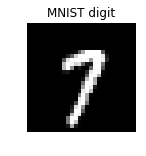

In [ ]:
img.show(figsize=(2,2), title='MNIST digit')

And you can transform them in various ways:

In [ ]:
img.rotate(35)

## Data augmentation

[`vision.transform`](/vision.transform.html#vision.transform) lets us do data augmentation. Simplest is to choose from a standard set of transforms, where the defaults are designed for photos:

In [ ]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



...or create the exact list you want:

In [ ]:
tfms = [rotate(degrees=(-20,20)), symmetric_warp(magnitude=(-0.3,0.3))]

You can apply these transforms to your images by using their `apply_tfms` method.

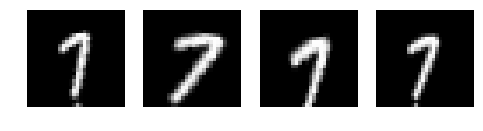

In [ ]:
fig,axes = plt.subplots(1,4,figsize=(8,2))
for ax in axes: ds[0][0].apply_tfms(tfms).show(ax=ax)

You can create a [`DataBunch`](/basic_data.html#DataBunch) with your transformed training and validation data loaders in a single step, passing in a tuple of *(train_tfms, valid_tfms)*:

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=(tfms, []))

## Training and interpretation

Now you're ready to train a model. To create a model, simply pass your [`DataBunch`](/basic_data.html#DataBunch) and a model creation function (such as one provided by [`vision.models`](/vision.models.html#vision.models) or [<code>torchvision.models</code>](https://pytorch.org/docs/stable/torchvision/models.html#torchvision-models)) to [`create_cnn`](/vision.learner.html#create_cnn), and call [`fit`](/basic_train.html#fit):

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(1)

Total time: 00:09
epoch  train_loss  valid_loss  accuracy
1      0.129880    0.049060    0.983808  (00:09)



Now we can take a look at the most incorrect images, and also the classification matrix.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

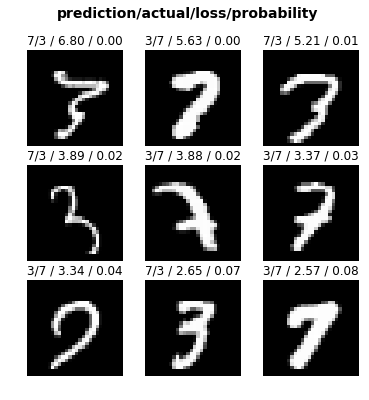

In [ ]:
interp.plot_top_losses(9, figsize=(6,6))

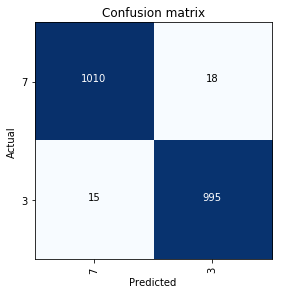

In [ ]:
interp.plot_confusion_matrix()

To simply predict the result of a new image (of type [`Image`](/vision.image.html#Image), so opened with [`open_image`](/vision.image.html#open_image) for instance), just use `learn.predict`. It returns the class, its index and the probabilities of each class.

In [ ]:
img = learn.data.train_ds[0][0]
learn.predict(img)

('7', tensor(0), tensor([0.9835, 0.0165]))